In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityamahimkar/iqothnccd-lung-cancer-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/aditya/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2


In [16]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [18]:
DATA_DIR = '/Users/aditya/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2'  # Update path if needed

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_data = datasets.ImageFolder(root=DATA_DIR, transform=transform)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3)  # 3 classes: Normal, Benign, Malignant
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [21]:
def train(model, loader):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(loader), correct / total

def evaluate(model, loader):
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return val_loss / len(loader), correct / total


In [22]:
train_losses, val_losses, train_accs, val_accs = [], [], [], []
for epoch in range(10):
    tr_loss, tr_acc = train(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_accs.append(tr_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={tr_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={tr_acc:.4f}, Val Acc={val_acc:.4f}")


Epoch 1: Train Loss=0.3531, Val Loss=0.1260, Train Acc=0.8647, Val Acc=0.9653
Epoch 2: Train Loss=0.1306, Val Loss=0.0684, Train Acc=0.9527, Val Acc=0.9730
Epoch 3: Train Loss=0.0599, Val Loss=0.0118, Train Acc=0.9865, Val Acc=1.0000
Epoch 4: Train Loss=0.0190, Val Loss=0.0057, Train Acc=0.9942, Val Acc=1.0000
Epoch 5: Train Loss=0.0165, Val Loss=0.0035, Train Acc=0.9961, Val Acc=1.0000
Epoch 6: Train Loss=0.0121, Val Loss=0.0003, Train Acc=0.9961, Val Acc=1.0000
Epoch 7: Train Loss=0.0027, Val Loss=0.0001, Train Acc=0.9990, Val Acc=1.0000
Epoch 8: Train Loss=0.0013, Val Loss=0.0000, Train Acc=1.0000, Val Acc=1.0000
Epoch 9: Train Loss=0.0009, Val Loss=0.0000, Train Acc=1.0000, Val Acc=1.0000
Epoch 10: Train Loss=0.0009, Val Loss=0.0001, Train Acc=1.0000, Val Acc=1.0000


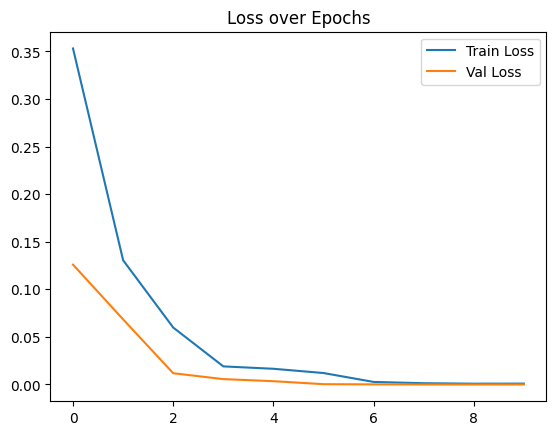

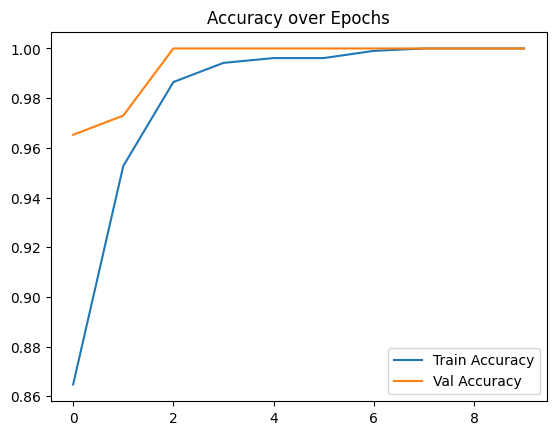

In [25]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.legend()
plt.show()

plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()


In [26]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
          Flatten-10                [-1, 50176]               0
           Linear-11                  [-1, 128]       6,422,656
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

In [27]:
from torchviz import make_dot

sample_input = torch.randn(1, 3, 224, 224).to(device)
output = model(sample_input)

make_dot(output, params=dict(model.named_parameters())).render("trained_cnn", format="png")


'trained_cnn.png'

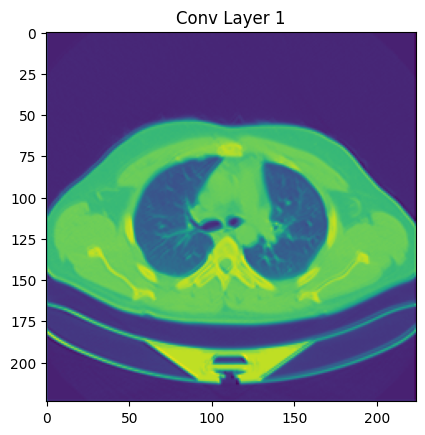

In [35]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn.functional as F

# Get intermediate outputs after each conv
image = next(iter(train_loader))[0][0].unsqueeze(0).to(device)  # One image
activations = []

x = image
for layer in model.conv:
    x = layer(x)
    if isinstance(layer, nn.Conv2d):
        activations.append(x[0][0].cpu().detach().numpy())

# Animate
fig, ax = plt.subplots()
img = ax.imshow(activations[0], cmap='viridis', animated=True)
plt.title("CNN Activation Flow")

def update(frame):
    img.set_array(activations[frame])
    ax.set_title(f"Conv Layer {frame+1}")
    return img,

ani = animation.FuncAnimation(fig, update, frames=len(activations), blit=True, repeat=False)
plt.show()


In [36]:
ani.save("cnn_activation_flow.gif", writer='pillow')